# Preparations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# show all cols in df
pd.set_option('display.max_columns', None)

# Function to do all the preprocessing

def preprocess_train_test(train_df, test_df):
    def preprocess_single(df):
        df_copy = df.copy()

        # Ensure 'trans_date_trans_time' is in datetime format
        df_copy['trans_date_trans_time'] = pd.to_datetime(df_copy['trans_date_trans_time'])
        df_copy['unix_time'] = pd.to_datetime(df_copy['unix_time'], unit='s')

        # Get month of year, day of week, and hour of day for transactions
        df_copy['trans_day_of_week'] = df_copy['trans_date_trans_time'].dt.day_name()
        df_copy['trans_month'] = df_copy['trans_date_trans_time'].dt.month_name()

        # Create 'time_of_day' column
        df_copy['time_of_day'] = (df_copy['trans_date_trans_time'].dt.hour * 60 + df_copy['trans_date_trans_time'].dt.minute) / (24 * 60)

        # Calculate age in years
        df_copy['dob'] = pd.to_datetime(df_copy['dob'])
        df_copy['age'] = df_copy['trans_date_trans_time'].dt.year - df_copy['dob'].dt.year - (
            (df_copy['trans_date_trans_time'].dt.month < df_copy['dob'].dt.month) |
            ((df_copy['trans_date_trans_time'].dt.month == df_copy['dob'].dt.month) & (df_copy['trans_date_trans_time'].dt.day < df_copy['dob'].dt.day))
        )

        # Sort the DataFrame by 'cc_num' and 'trans_date_trans_time'
        df_copy.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)

        # Group by 'cc_num' and calculate the time difference
        df_copy['last_purchased'] = df_copy.groupby('cc_num')['trans_date_trans_time'].diff()

        # For the first transaction for each 'cc_num', set 'last_purchased' to NaT
        df_copy['last_purchased'] = df_copy['last_purchased'].fillna(pd.NaT)

        # Convert 'last_purchased' to numerical format (total number of seconds)
        df_copy['last_purchased_secs'] = df_copy['last_purchased'].dt.total_seconds()

        # Define the Haversine distance function
        def haversine(lat1, lon1, lat2, lon2):
            R = 6371  # Radius of the Earth in kilometers
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
            return R * c

        # Calculate the distance to the last purchase
        df_copy['last_merch_lat'] = df_copy.groupby('cc_num')['merch_lat'].shift()
        df_copy['last_merch_long'] = df_copy.groupby('cc_num')['merch_long'].shift()

        df_copy['distance_last_purchase'] = haversine(df_copy['merch_lat'], df_copy['merch_long'], df_copy['last_merch_lat'], df_copy['last_merch_long'])

        # For the first transaction for each 'cc_num', set 'distance_last_purchase' to NaN
        df_copy['distance_last_purchase'] = df_copy['distance_last_purchase'].fillna(np.nan)

        # Create 'same_merchant_with_last_purchase' column
        df_copy['last_merchant'] = df_copy.groupby('cc_num')['merchant'].shift()
        df_copy['same_merchant_with_last_purchase'] = (df_copy['merchant'] == df_copy['last_merchant'])

        # Drop the temporary columns
        df_copy.drop(columns=['last_merch_lat', 'last_merch_long', 'last_merchant'], inplace=True)

        # Drop the specified columns
        df_copy.drop(columns=['last_purchased', 'city', 'street', 'last', 'first', 'job', 'cc_num', 'merchant', 'state', 'zip', 'lat', 'long', 'merch_lat', 'merch_long', 'trans_num', 'unix_time', 'dob'], inplace=True)

        # Sort the DataFrame by the original index to maintain the original order
        df_copy.sort_index(inplace=True)

        return df_copy

    train_df_preprocessed = preprocess_single(train_df)
    test_df_preprocessed = preprocess_single(test_df)

    return train_df_preprocessed, test_df_preprocessed

# Takes in processsed train and test data, removes all January 2019 data, and returns train, val, test
def process_fraud_data(train_df_preprocessed, test_df_preprocessed):
    # Combine the preprocessed data
    combined_df = pd.concat([train_df_preprocessed, test_df_preprocessed])

    # Remove rows where 'last_purchased_secs' is NaN
    combined_df = combined_df.dropna(subset=['last_purchased_secs'])

    # Remove all January 2019 data
    combined_df = combined_df[~((combined_df['trans_date_trans_time'].dt.year == 2019) & (combined_df['trans_date_trans_time'].dt.month == 1))]

    # Drop trans_date_trans_time
    combined_df = combined_df.drop(columns=['trans_date_trans_time'])

    # Split the combined data into train, validation, and test sets by order
    total_samples = len(combined_df)
    train_end = int(0.64 * total_samples)
    val_end = int(0.80 * total_samples)

    train_data = combined_df.iloc[:train_end]
    val_data = combined_df.iloc[train_end:val_end]
    test_data = combined_df.iloc[val_end:]

    return train_data, val_data, test_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv("/content/drive/Shared drives/Machine Learning/Project/fraudTrain.csv", index_col=0)
test_df = pd.read_csv("/content/drive/Shared drives/Machine Learning/Project/fraudTest.csv", index_col=0)
train_preprocessed, test_preprocessed = preprocess_train_test(train_df, test_df)
train, val, test = process_fraud_data(train_preprocessed, train_preprocessed)

categorical_features = ['category', 'gender', 'trans_day_of_week', 'trans_month', 'same_merchant_with_last_purchase']
continuous_features = ['amt', "city_pop", "time_of_day", "age", 'last_purchased_secs', 'distance_last_purchase']




In [ ]:
train_fraud = train[train["is_fraud"]==1]
binning = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
train_fraud_lca_con = pd.DataFrame(binning.fit_transform(train_fraud[continuous_features]).astype(int),
                              columns=continuous_features,
                              index=train_fraud.index).astype(str) # Use the original DataFrame's index
#train_lca_con.columns = continuous_features # No longer needed
train_fraud_lca = pd.concat([train_fraud_lca_con, train_fraud[categorical_features]], axis=1)
train_fraud_lca = pd.get_dummies(train_fraud_lca).astype(int)

test_fraud = test[test["is_fraud"]==1]
test_fraud_lca_con = pd.DataFrame(binning.transform(test_fraud[continuous_features]).astype(int),
                              columns=continuous_features,
                              index=test_fraud.index).astype(str) # Use the original DataFrame'
test_fraud_lca = pd.concat([test_fraud_lca_con, test_fraud[categorical_features]], axis=1)
test_fraud_lca = pd.get_dummies(test_fraud_lca).astype(int)

# Ensure all columns of train are in test
test_fraud_lca = test_fraud_lca.reindex(columns=train_fraud_lca.columns, fill_value=0)

train_fraud_lca.head()


,same_merchant_with_last_purchase,amt_0,amt_1,amt_2,amt_3,city_pop_0,city_pop_1,city_pop_2,city_pop_3,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,age_0,age_1,age_2,age_3,last_purchased_secs_0,last_purchased_secs_1,last_purchased_secs_2,last_purchased_secs_3,distance_last_purchase_0,distance_last_purchase_1,distance_last_purchase_2,distance_last_purchase_3,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M,trans_day_of_week_Friday,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday,trans_month_April,trans_month_August,trans_month_December,trans_month_February,trans_month_January,trans_month_July,trans_month_June,trans_month_March,trans_month_May,trans_month_November,trans_month_October,trans_month_September
52578,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52579,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52587,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52601,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52613,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Engineeri val & test in the same way as train set, if the one-hot encoding doesn't exist in test set, fill False
train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
val = pd.get_dummies(val, columns=categorical_features, drop_first=True)
val = val.reindex(columns=train.columns, fill_value=0)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)
test = test.reindex(columns=train.columns, fill_value=0)
train.head()

,amt,city_pop,is_fraud,time_of_day,age,last_purchased_secs,distance_last_purchase,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday,trans_month_August,trans_month_December,trans_month_February,trans_month_January,trans_month_July,trans_month_June,trans_month_March,trans_month_May,trans_month_November,trans_month_October,trans_month_September,same_merchant_with_last_purchase_True
52525,19.46,1423,0,0.001389,20,16027.0,155.644412,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
52526,13.01,471,0,0.002083,51,163101.0,121.187723,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
52527,50.02,471,0,0.003472,77,55381.0,28.230127,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
52528,6.11,192805,0,0.004167,55,91351.0,132.898691,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
52529,32.14,18408,0,0.005556,46,971.0,81.694148,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [ ]:
x_train = train.drop(columns=['is_fraud'])
y_train = train['is_fraud']
x_val = val.drop(columns=['is_fraud'])
y_val = val['is_fraud']
x_test = test.drop(columns=['is_fraud'])
y_test = test['is_fraud']

# Classification Report

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


svm
svm
svm
svm

Classification Report for xgb_model_balanced_Val:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    396104
           1       0.97      0.90      0.94      2002

    accuracy                           1.00    398106
   macro avg       0.99      0.95      0.97    398106
weighted avg       1.00      1.00      1.00    398106


Classification Report for xgb_model_balanced_Test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    494830
           1       0.95      0.91      0.93      2802

    accuracy                           1.00    497632
   macro avg       0.97      0.95      0.96    497632
weighted avg       1.00      1.00      1.00    497632


Classification Report for logi_model_balanced_Val:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    396104
           1       0.41      0.28      0.33      2002

    accurac

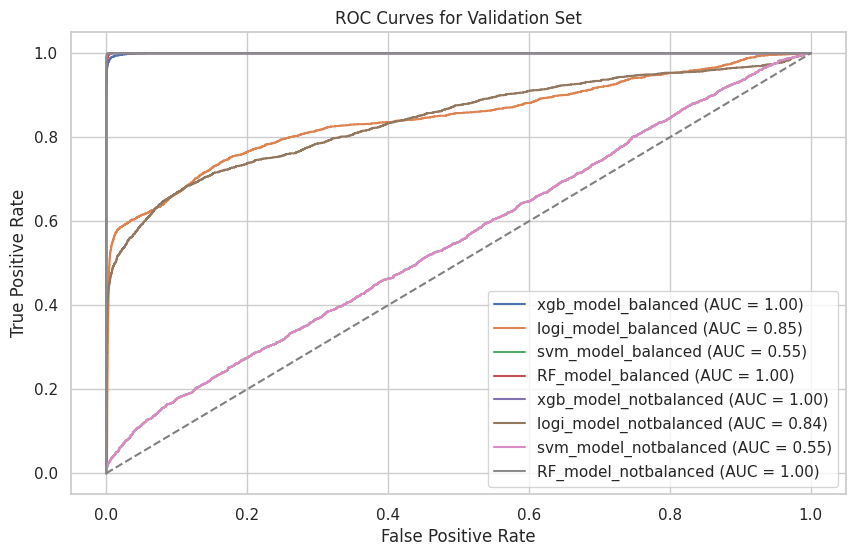

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, roc_curve
)

# Initialize lists to store model performance metrics
metrics_list = []
classification_reports = {}
roc_curves = {}  # Only for validation set

# Loop through each model file and evaluate on both validation and test sets
model_dir = "/content/drive/Shared drives/Machine Learning/Project/final_models"
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pkl")]
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)

    # Load the model
    with open(model_path, 'rb') as model_file:
        model = pickle.load(model_file)

    # Iterate over both validation and test datasets
    for dataset_name, (x_data, y_data) in zip(["Val", "Test"], [(x_val, y_val), (x_test, y_test)]):

        # Handle logistic regression from statsmodels differently
        if "logi" in model_path.lower():
            x_data_with_const = sm.add_constant(x_data.astype(float))  # Ensure constant term is added
            y_prob = model.predict(x_data_with_const)
            y_pred = (y_prob >= 0.5).astype(int)

        # Handle SVM separately using probability calibration
        elif "svm" in model_path.lower():
            print("svm")
            y_pred = model.predict(x_data)
            calibrated_svm = CalibratedClassifierCV(model)
            calibrated_svm.fit(x_val, y_val)  # Calibrate using validation set
            y_prob = calibrated_svm.predict_proba(x_data)[:, 1]

        else:
            y_pred = model.predict(x_data)
            y_prob = model.predict_proba(x_data)[:, 1] if hasattr(model, "predict_proba") else None

        # Compute metrics
        precision = precision_score(y_data, y_pred)
        recall = recall_score(y_data, y_pred)
        f1 = f1_score(y_data, y_pred)
        roc_auc = roc_auc_score(y_data, y_prob) if y_prob is not None else None

        # Store results
        model_name = os.path.basename(model_path).replace(".pkl", "")
        metrics_list.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        })

        # Store classification report
        classification_reports[f"{model_name}_{dataset_name}"] = classification_report(y_data, y_pred)

        # Store ROC curve **only for validation set**
        if dataset_name == "Val" and y_prob is not None:
            fpr, tpr, _ = roc_curve(y_data, y_prob)
            roc_curves[model_name] = (fpr, tpr)

# Convert results to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Print all classification reports
for model_key, report in classification_reports.items():
    print(f"\nClassification Report for {model_key}:\n{report}")

# Plot ROC Curves **only for validation set**
plt.figure(figsize=(10, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {metrics_df.loc[(metrics_df['Model'] == model_name) & (metrics_df['Dataset'] == 'Val'), 'ROC AUC'].values[0]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Validation Set")
plt.legend()
plt.show()


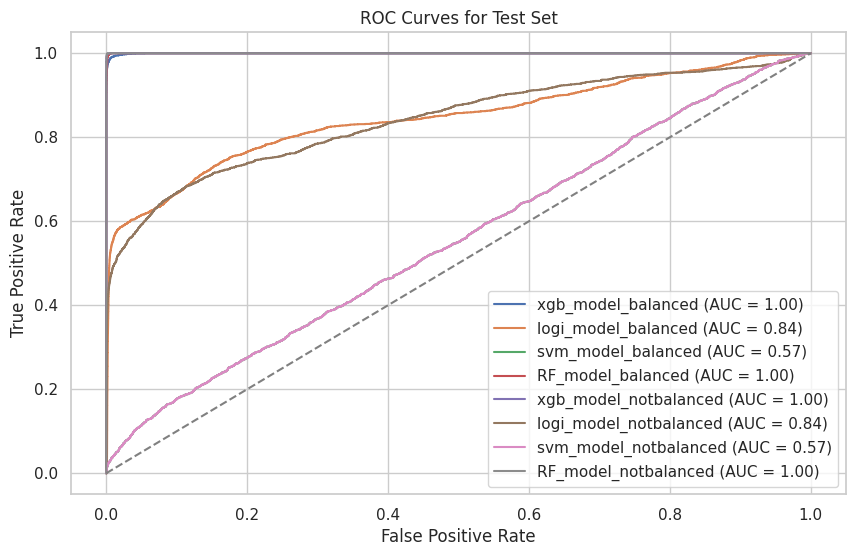

In [ ]:
plt.figure(figsize=(10, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {metrics_df.loc[(metrics_df['Model'] == model_name) & (metrics_df['Dataset'] == 'Test'), 'ROC AUC'].values[0]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Test Set")
plt.legend()
plt.show()


## Recall & F1 score comparison

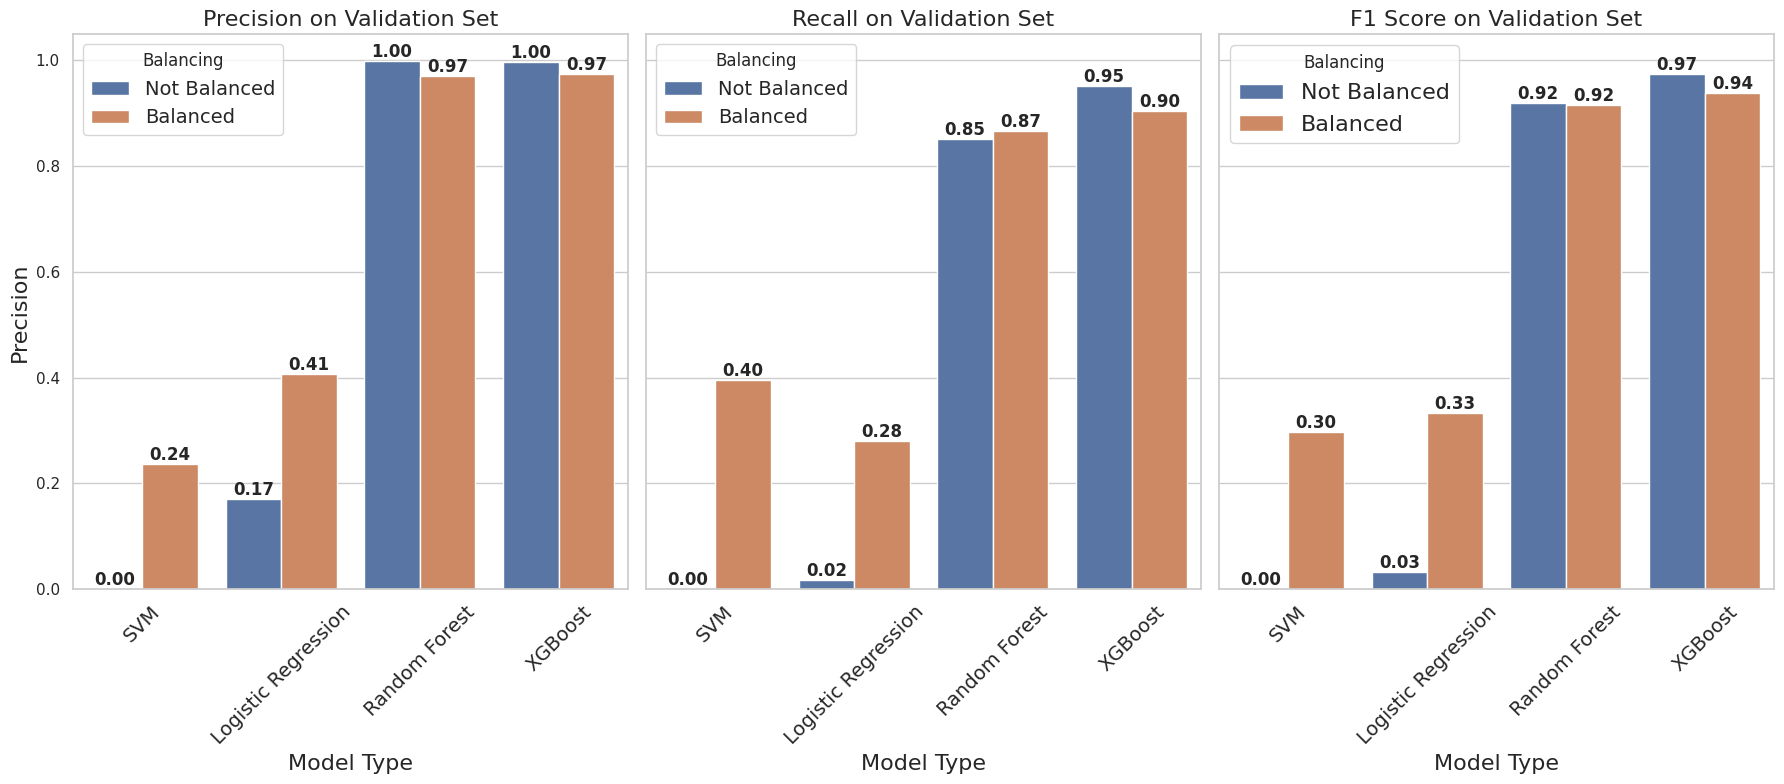

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure only validation set results are used
val_metrics = metrics_df[metrics_df["Dataset"] == "Val"].copy()

# Extract model type and balance status
val_metrics["Base Model"] = val_metrics["Model"].apply(lambda x: "_".join(x.split("_")[:-1]))  # Extract base model name
val_metrics["Balancing"] = val_metrics["Model"].apply(lambda x: "Not Balanced" if "notbalanced" in x else "Balanced")  # Label balancing

# Beautify model names
def beautify_model_name(model_name):
    if "xgb" in model_name.lower():
        return "XGBoost"
    elif "rf" in model_name.lower():
        return "Random Forest"
    elif "svm" in model_name.lower():
        return "SVM"
    elif "logi" in model_name.lower() or "logistic" in model_name.lower():
        return "Logistic Regression"
    else:
        return model_name

val_metrics["Base Model"] = val_metrics["Base Model"].apply(beautify_model_name)

# Sort values to ensure grouping is correct
# Define desired order for xticks: SVM -> Logistic Regression -> Random Forest -> XGBoost
model_order = ["SVM", "Logistic Regression", "Random Forest", "XGBoost"]

# Sort values to ensure grouping is correct
val_metrics["Base Model"] = pd.Categorical(val_metrics["Base Model"], categories=model_order, ordered=True)
val_metrics = val_metrics.sort_values(by=["Base Model", "Balancing"], ascending=[True, False])


# Set plotting style
sns.set(style="whitegrid")

# Create a 1x3 grid of bar plots
fig, axes = plt.subplots(1, 3, figsize=(18,8), sharey=True)

# Function to annotate bars with values
def annotate_bars(ax):
  count = 0
  for p in ax.patches:
    if count in (8, 9,17,18,29,30):
      count+=1
      continue
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    count+=1

# Plot Precision
ax0 = sns.barplot(x="Base Model", y="Precision", hue="Balancing", data=val_metrics, ax=axes[0])
axes[0].set_title("Precision on Validation Set",fontsize=16)
axes[0].set_xlabel("Model Type",fontsize=16)
axes[0].set_ylabel("Precision",fontsize=16)
axes[0].tick_params(axis='x', rotation=45,labelsize=14)
axes[0].legend(title="Balancing",fontsize=14)
annotate_bars(ax0)

# Plot Recall
ax1 = sns.barplot(x="Base Model", y="Recall", hue="Balancing", data=val_metrics, ax=axes[1])
axes[1].set_title("Recall on Validation Set",fontsize=16)
axes[1].set_xlabel("Model Type",fontsize=16)
axes[1].set_ylabel("Recall",fontsize=16)
axes[1].tick_params(axis='x', rotation=45,labelsize=14)
axes[1].legend(title="Balancing",fontsize=14)
annotate_bars(ax1)

# Plot F1 Score
ax2 = sns.barplot(x="Base Model", y="F1 Score", hue="Balancing", data=val_metrics, ax=axes[2])
axes[2].set_title("F1 Score on Validation Set",fontsize=16)
axes[2].set_xlabel("Model Type",fontsize=16)
axes[2].set_ylabel("F1 Score",fontsize=16)
axes[2].tick_params(axis='x', rotation=45,labelsize=14)
axes[2].legend(title="Balancing",fontsize=16)
annotate_bars(ax2)

# Adjust layout
plt.tight_layout()
plt.show()


# Selected model

In [ ]:
# filter xgboost without balancing's result
metrics_df[metrics_df["Model"] == "xgb_model_notbalanced"]

,Model,Dataset,Precision,Recall,F1 Score,ROC AUC
8,xgb_model_notbalanced,Val,0.996339,0.951548,0.973429,0.999982
9,xgb_model_notbalanced,Test,0.993318,0.955032,0.973799,0.999978


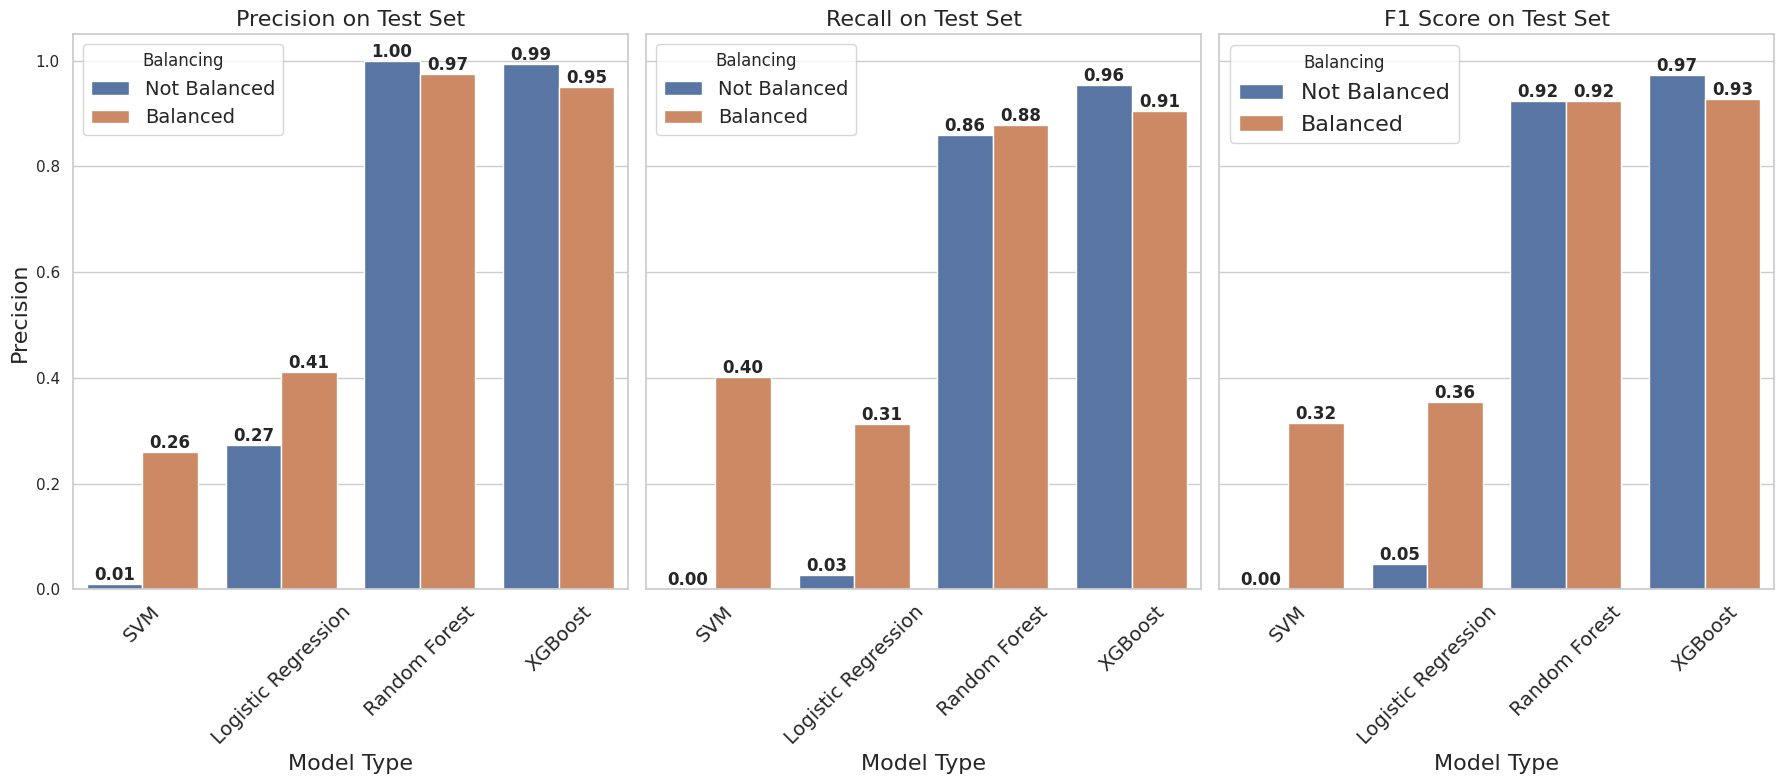

In [ ]:
# Ensure only test set results are used
test_metrics = metrics_df[metrics_df["Dataset"] == "Test"].copy()

# Extract model type and balance status
test_metrics["Base Model"] = test_metrics["Model"].apply(lambda x: "_".join(x.split("_")[:-1]))  # Extract base model name
test_metrics["Balancing"] = test_metrics["Model"].apply(lambda x: "Not Balanced" if "notbalanced" in x else "Balanced")  # Label balancing

# Beautify model names
def beautify_model_name(model_name):
    if "xgb" in model_name.lower():
        return "XGBoost"
    elif "rf" in model_name.lower():
        return "Random Forest"
    elif "svm" in model_name.lower():
        return "SVM"
    elif "logi" in model_name.lower() or "logistic" in model_name.lower():
        return "Logistic Regression"
    else:
        return model_name

test_metrics["Base Model"] = test_metrics["Base Model"].apply(beautify_model_name)

# Define desired order for xticks: SVM -> Logistic Regression -> Random Forest -> XGBoost
model_order = ["SVM", "Logistic Regression", "Random Forest", "XGBoost"]

# Sort values to ensure grouping is correct
test_metrics["Base Model"] = pd.Categorical(test_metrics["Base Model"], categories=model_order, ordered=True)
test_metrics = test_metrics.sort_values(by=["Base Model", "Balancing"], ascending=[True, False])

# Set plotting style
sns.set(style="whitegrid")

# Create a 1x3 grid of bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Function to annotate bars with values
def annotate_bars(ax):
    count = 0
    for p in ax.patches:
        if count in (8, 9, 17, 18, 29, 30):
            count += 1
            continue
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
        count += 1

# Plot Precision
ax0 = sns.barplot(x="Base Model", y="Precision", hue="Balancing", data=test_metrics, ax=axes[0])
axes[0].set_title("Precision on Test Set", fontsize=16)
axes[0].set_xlabel("Model Type", fontsize=16)
axes[0].set_ylabel("Precision", fontsize=16)
axes[0].tick_params(axis='x', rotation=45, labelsize=14)
axes[0].legend(title="Balancing", fontsize=14)
annotate_bars(ax0)

# Plot Recall
ax1 = sns.barplot(x="Base Model", y="Recall", hue="Balancing", data=test_metrics, ax=axes[1])
axes[1].set_title("Recall on Test Set", fontsize=16)
axes[1].set_xlabel("Model Type", fontsize=16)
axes[1].set_ylabel("Recall", fontsize=16)
axes[1].tick_params(axis='x', rotation=45, labelsize=14)
axes[1].legend(title="Balancing", fontsize=14)
annotate_bars(ax1)

# Plot F1 Score
ax2 = sns.barplot(x="Base Model", y="F1 Score", hue="Balancing", data=test_metrics, ax=axes[2])
axes[2].set_title("F1 Score on Test Set", fontsize=16)
axes[2].set_xlabel("Model Type", fontsize=16)
axes[2].set_ylabel("F1 Score", fontsize=16)
axes[2].tick_params(axis='x', rotation=45, labelsize=14)
axes[2].legend(title="Balancing", fontsize=16)
annotate_bars(ax2)

# Adjust layout
plt.tight_layout()
plt.show()


# LCA

In [ ]:
# install stepmix
!pip install stepmix

In [ ]:
# load lca model
import pickle
import stepmix

filename = '/content/drive/Shared drives/Machine Learning/Project/final_models/lca_model.sav'
lca_model = pickle.load(open(filename, 'rb'))

# Business Impact

In [ ]:
import numpy as np
# Load the selected model
model_path = "/content/drive/Shared drives/Machine Learning/Project/final_models/xgb_model_balanced.pkl"
with open(model_path, 'rb') as model_file:
    xgb_model_balanced = pickle.load(model_file)

# Predict on the test set
y_pred = xgb_model_balanced.predict(x_test)
y_prob = xgb_model_balanced.predict_proba(x_test)[:, 1]

# Calculate recall and fraud money recall
recall = recall_score(y_test, y_pred)
fraud_money_recall = np.sum(y_test[y_pred == 1] * test['amt'][y_pred == 1]) / np.sum(y_test * test['amt'])

print(f"Overall Recall: {recall}")
print(f"Fraud Money Recall: {fraud_money_recall}")
print(np.sum(y_test[y_pred == 1] * test['amt'][y_pred == 1]))
print(np.sum(y_test * test['amt']))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:07:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Overall Recall: 0.9057815845824411
Fraud Money Recall: 0.969472366726735
1466908.26
1513099.6100000003


In [ ]:
model_path = "/content/drive/Shared drives/Machine Learning/Project/final_models/xgb_model_notbalanced.pkl" # Changed to the notbalanced model
with open(model_path, 'rb') as model_file:
    xgb_model_notbalanced = pickle.load(model_file)
# predict on test set
# Predict on the test set
y_pred = xgb_model_notbalanced.predict(x_test)
y_prob = xgb_model_notbalanced.predict_proba(x_test)[:, 1]

# Calculate recall and fraud money recall
recall = recall_score(y_test, y_pred)
fraud_money_recall = np.sum(y_test[y_pred == 1] * test['amt'][y_pred == 1]) / np.sum(y_test * test['amt'])

print(f"Overall Recall: {recall}")
print(f"Fraud Money Recall: {fraud_money_recall}")
print(np.sum(y_test[y_pred == 1] * test['amt'][y_pred == 1]))
print(np.sum(y_test * test['amt']))

Overall Recall: 0.9550321199143469
Fraud Money Recall: 0.9850874193272707
1490535.3900000001
1513099.6100000003


In [ ]:
import pandas as pd
# Predict clusters for fraud data in the test set
test_fraud_clusters = lca_model.predict(test_fraud_lca)

# Create a DataFrame with the cluster predictions
test_fraud_clusters_df = pd.DataFrame({'cluster': test_fraud_clusters}, index=test_fraud.index)

# Left join the cluster predictions to the test_df DataFrame
test = test.join(test_fraud_clusters_df, how='left')
test

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,amt,city_pop,is_fraud,time_of_day,age,last_purchased_secs,distance_last_purchase,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday,trans_month_August,trans_month_December,trans_month_February,trans_month_January,trans_month_July,trans_month_June,trans_month_March,trans_month_May,trans_month_November,trans_month_October,trans_month_September,same_merchant_with_last_purchase_True,cluster
799013,50.56,737,0,0.947222,32,20638.0,94.540838,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,0,True,False,False,0,False,False,False,0,0,0,False,NaN
799014,11.09,139,0,0.947917,65,18859.0,82.891431,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,0,True,False,False,0,False,False,False,0,0,0,False,NaN
799015,41.20,1120,0,0.948611,62,159665.0,32.075905,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,0,True,False,False,0,False,False,False,0,0,0,False,NaN
799016,8.65,13602,0,0.948611,35,8883.0,120.786297,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,0,True,False,False,0,False,False,False,0,0,0,False,NaN
799017,59.24,18128,0,0.949306,29,4263.0,88.726573,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,0,True,False,False,0,False,False,False,0,0,0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,258,0,0.508333,58,16781.0,112.032046,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,0,False,False,False,0,True,False,False,0,0,0,False,NaN
1296671,51.70,100,0,0.508333,40,7962.0,94.988187,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,0,False,False,False,0,True,False,False,0,0,0,False,NaN
1296672,105.93,899,0,0.508333,52,29074.0,177.104191,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,0,False,False,False,0,True,False,False,0,0,0,False,NaN
1296673,74.90,1126,0,0.509028,39,91018.0,118.969517,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,0,False,False,False,0,True,False,False,0,0,0,False,NaN


In [ ]:
import pandas as pd
import numpy as np
# Load the selected model
model_path = "/content/drive/Shared drives/Machine Learning/Project/final_models/xgb_model_notbalanced.pkl" # Changed to the notbalanced model
with open(model_path, 'rb') as model_file:
    xgb_model_notbalanced = pickle.load(model_file) # Renamed the loaded model

# Calculate recall and fraud money recall for each cluster
cluster_metrics = []
for cluster in test['cluster'].unique():
    if pd.isna(cluster):
        continue
    cluster_data = test[test['cluster'] == cluster]
    y_test_cluster = cluster_data['is_fraud']
    y_pred_cluster = xgb_model_notbalanced.predict(cluster_data.drop(columns=['is_fraud', 'cluster'])) # Use the notbalanced model
    recall_cluster = recall_score(y_test_cluster, y_pred_cluster)
    fraud_money_recall_cluster = np.sum(y_test_cluster[y_pred_cluster == 1] * cluster_data['amt'][y_pred_cluster == 1]) / np.sum(y_test_cluster * cluster_data['amt'])

    cluster_size = len(cluster_data)
    total_size = test["cluster"].isin([0,1,2,3]).sum()
    cluster_percentage = (cluster_size / total_size) * 100
    total_fraud_money = np.sum(y_test_cluster * cluster_data['amt'])
    percentage_of_total_money = (total_fraud_money / np.sum(test['is_fraud'] * test['amt'])) * 100

    cluster_metrics.append({
        'cluster': cluster,
        'recall': recall_cluster,
        'fraud_money_recall': fraud_money_recall_cluster,
        'fraud_money_detected': np.sum(y_test_cluster[y_pred_cluster == 1] * cluster_data['amt'][y_pred_cluster == 1]),
        'total_fraud_money': total_fraud_money,
        'cluster_size': cluster_size,
        'cluster_percentage': cluster_percentage,
        'percentage_of_total_money': percentage_of_total_money
    })

cluster_metrics_df = pd.DataFrame(cluster_metrics)
cluster_metrics_df


,cluster,recall,fraud_money_recall,fraud_money_detected,total_fraud_money,cluster_size,cluster_percentage,percentage_of_total_money
0,1.0,0.984993,0.985223,552834.51,561126.32,733,26.159886,37.084559
1,3.0,0.844376,0.778235,15717.81,20196.74,649,23.162027,1.334792
2,2.0,0.988555,0.988524,701734.57,709880.95,699,24.946467,46.915679
3,0.0,0.991678,0.992577,220248.50,221895.60,721,25.731620,14.664970
